In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import pdb
from copy import deepcopy


In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
set_seed(0)

## Model & Dataset Code

In [ ]:
class MLP(nn.Module):

    def __init__(self, num_classes, in_dim, context_dim, h, out_dim):
        super(MLP, self).__init__()
        # Add class conditioned lookup table
        self.embedding_table = nn.Embedding(num_classes, in_dim + context_dim)
        self.embedding_table.weight.data.normal_(0, 1)
        # Create diffusion network
        self.network = nn.Sequential(nn.Linear(in_dim + context_dim, h), nn.Tanh(),
                                     nn.Linear(h, h), nn.Tanh(),
                                     nn.Linear(h, out_dim))

    def forward(self, x, context, target_class):
        class_embedding = self.embedding_table(target_class)
        x_t = torch.cat((x, context), dim=1)
        x_t_by_c = x_t + class_embedding
        return self.network(x_t_by_c)


class Dataset(torch.utils.data.Dataset):
    def __init__(self, dist1, dist2):
        self.dist1 = dist1
        self.dist2 = dist2
        assert self.dist1.shape == self.dist2.shape

    def __len__(self):
        return self.dist1.shape[0]

    def __getitem__(self, idx):
        return self.dist1[idx], self.dist2[idx]


def sample_multimodal_distribution(modes, std, batch_size=1000):
    dataset = []
    for i in range(batch_size):
        sample = np.random.randn(modes.shape[1]) * std
        mode_idx = np.random.randint(modes.shape[0])
        sample[0] += modes[mode_idx, 0]
        sample[1] += modes[mode_idx, 1]
        instance = np.concatenate((sample, np.array([mode_idx])))
        dataset.append(instance)
    return np.array(dataset, dtype="float32")

def train_rectified_flow(
    rectified_flow, optimizer, 
    train_dataloader, NB_EPOCHS, 
    eps=1e-15, contrastive_obj=False, 
    contrastive_lambda=0.05,# null_dropout=0.1, 
    num_classes=2
):

    for epoch in tqdm(range(NB_EPOCHS)):
        for z0_, z1c in (train_dataloader):
            
            z0_, z1c = z0_.to(device), z1c.to(device)
            t = torch.rand((z1c.shape[0], 1), device=device)
            z0 = z0_[:, :2] # remove dummy class index
            z1 = z1c[:, :2] # remove class index
            z_t = t * z1 + (1.-t) * z0
            target = z1 - z0
            pred = rectified_flow(z_t, t, target_class=z1c[:, 2].long())
            loss = (target - pred).view(pred.shape[0], -1).pow(2).sum(dim=1).mean()
            
            if contrastive_obj:
                negative_idx = torch.randperm(pred.shape[0])
                negatives = target[negative_idx]
                loss = loss - (negatives - pred).view(pred.shape[0], -1).pow(2).sum(dim=1).mean() * contrastive_lambda

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

### Create Source & Target Distributions

In [5]:
device = 'cuda'
batch_size = 2048
dataset_size = 10_000
nb_epochs = 2_000
wd = 0.01

In [6]:
theta_1 = np.array([0, 4*np.pi]) / 360 * 2 * np.pi
std = 0.5
radius = 5.
modes = np.array([(radius * x, radius * y) for x, y in zip(np.cos(theta_1), np.sin(theta_1))])
pi_1 = sample_multimodal_distribution(modes, std, batch_size=dataset_size)
pi_1_0 = pi_1[pi_1[:, 2] == 0, :2]
pi_1_1 = pi_1[pi_1[:, 2] == 1, :2]

In [7]:
theta_0 = np.array([180]) / 360 * 2 * np.pi
std = 0.5
radius = 15
modes = np.array([(radius * x, radius * y) for x, y in zip(np.cos(theta_0), np.sin(theta_0))])
pi_0 = sample_multimodal_distribution(modes, std, batch_size=dataset_size)

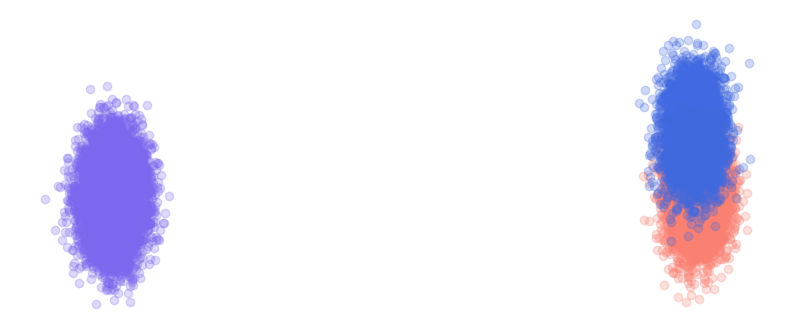

In [8]:
colors = [
    (250 / 255, 128 / 255, 114 / 255),
    (65 / 255, 105 / 255, 225 / 255)
]

plt.figure(figsize=(10, 4))

plt.scatter(pi_0[:, 0], pi_0[:, 1], color="mediumslateblue", alpha=0.25, marker="o")
plt.scatter(pi_1_0[:, 0], pi_1_0[:, 1], color=colors[0], alpha=0.25, marker="o")
plt.scatter(pi_1_1[:, 0], pi_1_1[:, 1], color=colors[1], alpha=0.25, marker="o")

# remove ticks
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [9]:
dataset = Dataset(pi_0, pi_1)
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

### Train Models

In [12]:
fm_model = MLP(num_classes=2, in_dim=2, context_dim=1, h=64, out_dim=2).to(device)
optimizer = torch.optim.Adam(fm_model.parameters(), lr=5e-3, weight_decay=wd)
fm_loss = train_rectified_flow(fm_model, optimizer, train_dataloader, nb_epochs, eps=1e-15)

100%|██████████| 2000/2000 [01:44<00:00, 19.13it/s]


In [10]:
cf_model = MLP(num_classes=2, in_dim=2, context_dim=1, h=64, out_dim=2).to(device)
optimizer = torch.optim.Adam(cf_model.parameters(), lr=5e-3, weight_decay=wd)
cf_loss = train_rectified_flow(
    cf_model, optimizer, train_dataloader, nb_epochs, eps=1e-15, 
    contrastive_obj=True, contrastive_lambda=0.5
)

100%|██████████| 2000/2000 [01:47<00:00, 18.68it/s]


### Create Sampler

In [11]:
def sample_fn(rectified_flow, T, pi_0):
    samples = [pi_0.clone().unsqueeze(0)]
    for i in (range(T)):
        t = torch.ones((pi_0.shape[0], 1), device=samples[-1].device) * i / T
        inp = samples[-1].squeeze(0)
        drift_pred = rectified_flow(inp[:, :2], t, inp[:, 2].long())
        next_sample = deepcopy(samples[-1].detach())
        next_sample[0, :, :2] = next_sample[0, :, :2] + drift_pred * 1. / T
        samples += [next_sample]
    return torch.cat(samples)

### Plot Results

In [12]:
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize

def compute_vertical_kde_density(y):
    kde = gaussian_kde(y, bw_method="scott")(y)  # Only using y-values for KDE
    return kde

In [13]:
modes = np.array([(radius * x, radius * y) for x, y in zip(np.cos(theta_0), np.sin(theta_0))])
test_pi_0 = sample_multimodal_distribution(modes, 0.5, batch_size=1000)
test_pi_0[:, 2] = torch.randint(0, 2, (test_pi_0.shape[0],))

/tmp/ipykernel_71577/171117297.py:3: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  test_pi_0[:, 2] = torch.randint(0, 2, (test_pi_0.shape[0],))


#### Baseline

In [23]:
test_pi_1 = sample_fn(fm_model, 1000, torch.from_numpy(test_pi_0).to(device))

test_pi_1_flat = test_pi_1.reshape(-1, 3)
test_pi_1_0 = test_pi_1_flat[test_pi_1_flat[:, 2] == 0, :2].reshape(1001, -1, 2)
test_pi_1_1 = test_pi_1_flat[test_pi_1_flat[:, 2] == 1, :2].reshape(1001, -1, 2)

x_1_0, y_1_0 = test_pi_1_0[-1, :, 0].cpu().detach().numpy(), test_pi_1_0[-1, :, 1].cpu().detach().numpy()
x_1_1, y_1_1 = test_pi_1_1[-1, :, 0].cpu().detach().numpy(), test_pi_1_1[-1, :, 1].cpu().detach().numpy()

y_min = min(y_1_0.min(), y_1_1.min())
y_max = max(y_1_0.max(), y_1_1.max())
y_grid = np.linspace(y_min, y_max, 500)

density_1_0 = compute_vertical_kde_density(y_1_0)
density_1_1 = compute_vertical_kde_density(y_1_1)

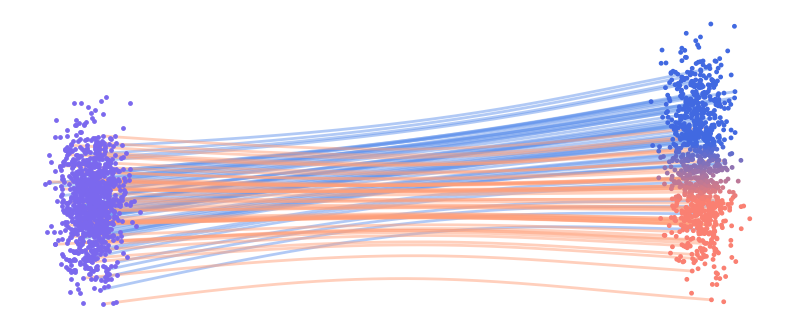

In [24]:
# # make figure size
plt.figure(figsize=(10, 4))

for sample in range(0, test_pi_1_1.shape[1], 10):
    x = test_pi_1_1[:, sample, 0].cpu().detach().numpy()
    y = test_pi_1_1[:, sample, 1].cpu().detach().numpy()
    plt.plot(x, y, c='cornflowerblue', linewidth=2., alpha=0.5, zorder=1)
for sample in range(0, test_pi_1_0.shape[1], 10):
    plt.plot(
        test_pi_1_0[:, sample, 0].cpu().detach().numpy(),
        test_pi_1_0[:, sample, 1].cpu().detach().numpy(),
        c='lightsalmon', linewidth=2., alpha=0.5, zorder=1
    )


colors = [
    (250 / 255, 128 / 255, 114 / 255),
    (65 / 255, 105 / 255, 225 / 255)
]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=2000)
norm = Normalize(
    vmin=min(density_1_0.min(), density_1_1.min()), 
    vmax=max(density_1_0.max(), density_1_1.max())
)

plt.scatter(test_pi_0[:, 0], test_pi_0[:, 1], color="mediumslateblue", alpha=1.0, s=6, zorder=2)
plt.scatter(
    test_pi_1_0[-1, :, 0].data.cpu().numpy(), 
    test_pi_1_0[-1, :, 1].data.cpu().numpy(), 
    alpha=1.0, s=6, zorder=2,
    c=test_pi_1_0[-1, :, 1].data.cpu().numpy(),
    cmap=custom_cmap, norm=norm
)
plt.scatter(
    test_pi_1_1[-1, :, 0].data.cpu().numpy(), 
    test_pi_1_1[-1, :, 1].data.cpu().numpy(), 
    alpha=1.0, s=6, zorder=2,
    c=test_pi_1_1[-1, :, 1].data.cpu().numpy(),
    cmap=custom_cmap, norm=norm
)
# remove ticks
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


#### Contrastive Flow Matching

In [14]:
cf_test_pi_1 = sample_fn(cf_model, 1000, torch.from_numpy(test_pi_0).to(device))

cf_test_pi_1_flat = cf_test_pi_1.reshape(-1, 3)
cf_test_pi_1_0 = cf_test_pi_1_flat[cf_test_pi_1_flat[:, 2] == 0, :2].reshape(1001, -1, 2)
cf_test_pi_1_1 = cf_test_pi_1_flat[cf_test_pi_1_flat[:, 2] == 1, :2].reshape(1001, -1, 2)


x_1_0, y_1_0 = cf_test_pi_1_0[-1, :, 0].cpu().detach().numpy(), cf_test_pi_1_0[-1, :, 1].cpu().detach().numpy()
x_1_1, y_1_1 = cf_test_pi_1_1[-1, :, 0].cpu().detach().numpy(), cf_test_pi_1_1[-1, :, 1].cpu().detach().numpy()

y_min = min(y_1_0.min(), y_1_1.min())
y_max = max(y_1_0.max(), y_1_1.max())
y_grid = np.linspace(y_min, y_max, 500)

density_1_0 = compute_vertical_kde_density(y_1_0)
density_1_1 = compute_vertical_kde_density(y_1_1)


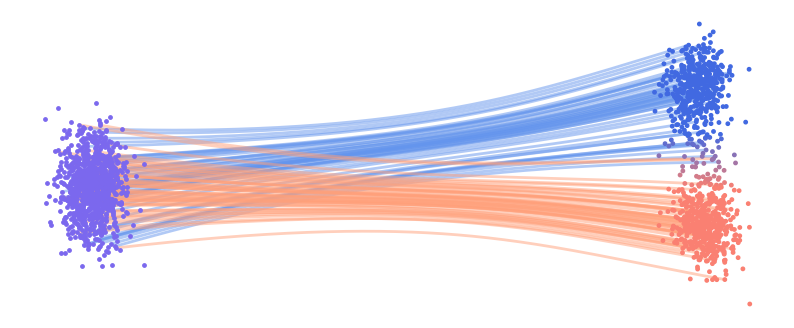

In [15]:
plt.figure(figsize=(10, 4))

for sample in range(0, cf_test_pi_1_1.shape[1], 10):
    x = cf_test_pi_1_1[:, sample, 0].cpu().detach().numpy()
    y = cf_test_pi_1_1[:, sample, 1].cpu().detach().numpy()
    plt.plot(x, y, c='cornflowerblue', linewidth=2., alpha=0.5, zorder=1)
for sample in range(0, cf_test_pi_1_0.shape[1], 10):
    plt.plot(
        cf_test_pi_1_0[:, sample, 0].cpu().detach().numpy(),
        cf_test_pi_1_0[:, sample, 1].cpu().detach().numpy(),
        c='lightsalmon', linewidth=2., alpha=0.5, zorder=1
    )


colors = [
    (250 / 255, 128 / 255, 114 / 255),
    (65 / 255, 105 / 255, 225 / 255)
]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=2000)
norm = Normalize(
    vmin=min(density_1_0.min(), density_1_1.min()), 
    vmax=max(density_1_0.max(), density_1_1.max())
)

plt.scatter(test_pi_0[:, 0], test_pi_0[:, 1], color="mediumslateblue", alpha=1.0, s=6, zorder=2)
plt.scatter(
    cf_test_pi_1_0[-1, :, 0].data.cpu().numpy(), 
    cf_test_pi_1_0[-1, :, 1].data.cpu().numpy(), 
    alpha=1.0, s=6, zorder=2,
    c=cf_test_pi_1_0[-1, :, 1].data.cpu().numpy(),
    cmap=custom_cmap, norm=norm
)
plt.scatter(
    cf_test_pi_1_1[-1, :, 0].data.cpu().numpy(), 
    cf_test_pi_1_1[-1, :, 1].data.cpu().numpy(), 
    alpha=1.0, s=6, zorder=2,
    c=cf_test_pi_1_1[-1, :, 1].data.cpu().numpy(),
    cmap=custom_cmap, norm=norm
)
# remove ticks
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()
